In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()

Running on CPU
Running on CPU


## Model

In [2]:
hidden_size = 128
input_size = 1
nav_size = 1

model1 = RNN_circular_LowEtAl_bridged(input_size,hidden_size,lr=0.0001,irnn=True,outputnn=False,Wx_normalize=False,activation=True,bias=False,nav_space=1,batch_size=64).to(device)

train = False

if train:
    _ = model1.train_gradual(epochs=4000)
    # model1.base_training_tsteps = 50
    # _ = model1.train(epochs=2000)
    model1.plot_losses(average=30)
else:
    model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_reduced_Gradual_lossiequaloroverj_maskonangle_lossscale_4000gradual.pt"))

# torch.save(model1.state_dict(), "../trained models/LowEtAl_bridged_reduced_Gradual_lossiequaloroverj_maskonangle_lossscale_4000gradual.pt")

In [3]:
_ = model1.train(epochs=10)

100%|██████████| 10/10 [00:00<00:00, 34.33it/s]


## Analysis

### Norm of activity per timestep

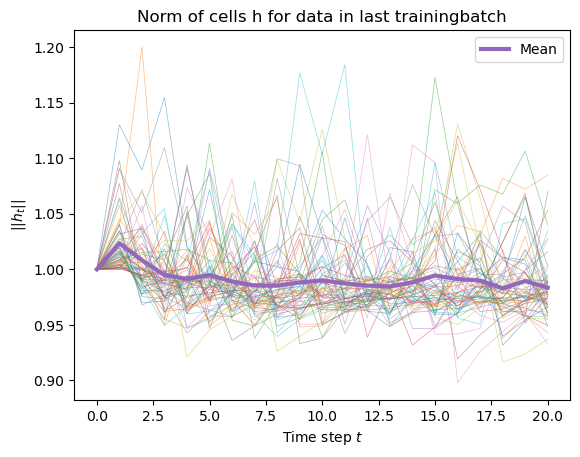

Mean norm:  0.9917718


In [4]:
def plot_norm(hts,avg_only=True):
    if avg_only:
        # Plot mean
        plt.plot(np.mean(hts,axis=1), linewidth=3, label="Mean")
    else:
        # Plot all in last batch
        plt.plot(hts, linewidth=0.5, alpha=0.5)
        # Plot mean
        plt.plot(np.mean(hts,axis=1), linewidth=3, label="Mean")
    plt.title("Norm of cells h for data in last trainingbatch")
    plt.xlabel(r"Time step $t$")
    plt.ylabel(r"$||h_t||$")
    plt.legend()
    plt.show()
    print("Mean norm: ", np.mean(hts))

htss = model1.hts.norm(dim=2)
htss = htss.cpu().detach().numpy()
plot_norm(htss,avg_only=False)

### Tuning curves

(40, 5000)


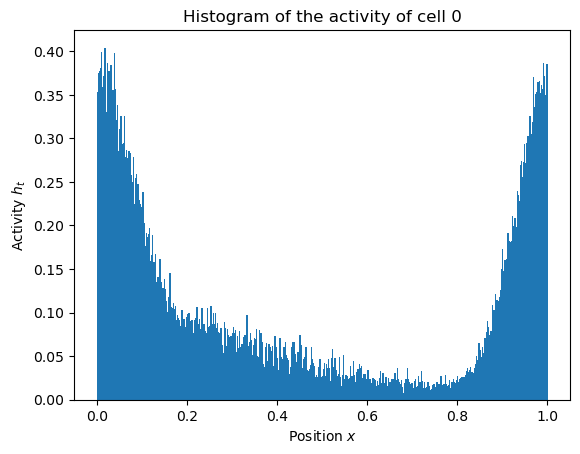

100%|██████████| 12/12 [00:17<00:00,  1.44s/it]


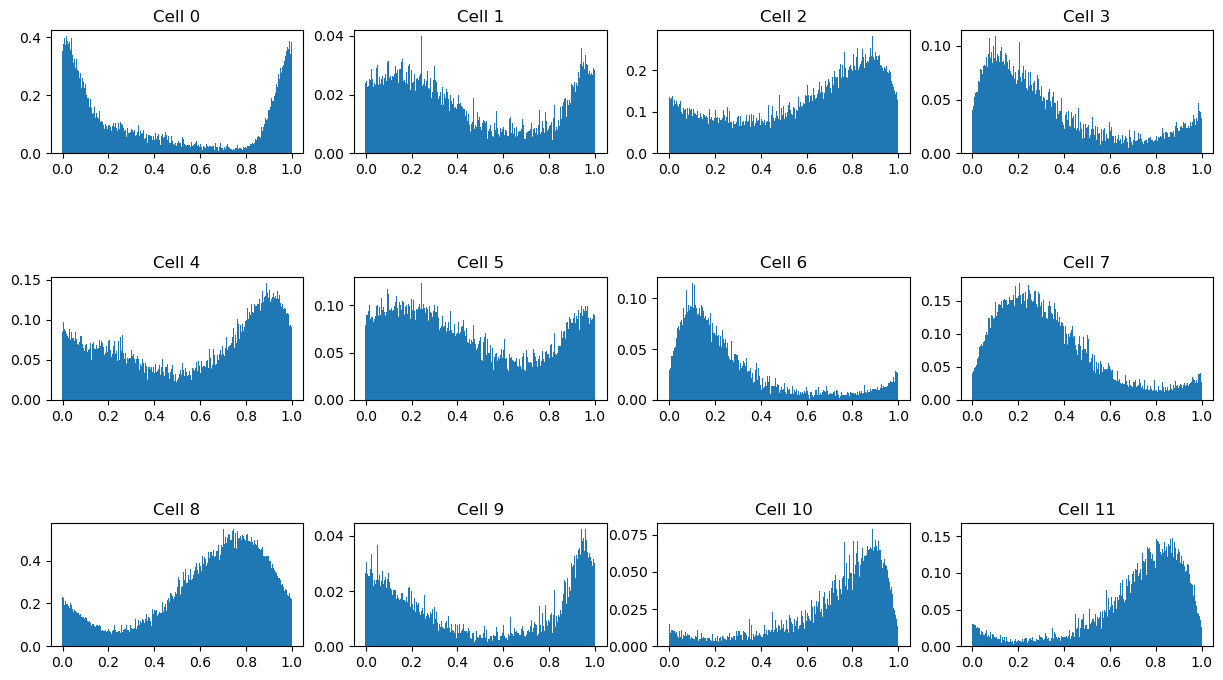

In [11]:
def tuning_curve(t_test=40,test_batch_size=5000, bins=2000, spherical_data=True):
    if spherical:
        data, _, labels = datagen_lowetal(5000,t_test)
    else:
        data,labels = datagen_circular_pm(5000,t_test,sigma=0.05,bound=0.5)
    
    
    # Get positions from labels
    xs = labels[0:test_batch_size]
    xs = xs.cpu().detach().numpy().T

    # Get the hidden states inferenced from the test data
    hts = model1(data[0:test_batch_size],raw=True)
    hts = hts.cpu().detach().numpy() # Shape [t_steps, batch_size, hidden_size] = [21, 64, 128]
    n_cells = hts.shape[2]
    
    import scipy.stats as stats

    activity = np.zeros((n_cells,bins))

    for k in range(n_cells):
        hts_k = abs(hts[1:,:,k])
        # Bins equally spaced from 0 to 1 in time_steps amount of bins
        bin_means, bin_edges, binnumber = stats.binned_statistic(xs.flatten(),hts_k.flatten(),statistic='mean',bins=bins)
        activity[k,:] = bin_means
        np.nan_to_num(activity,copy=False)
    return activity, bin_edges

def plot_tuning_curve(activity,bin_edges,k,spherical=False,linear=False,plot_head_frac=1/10,scale_to_one=False):
    if scale_to_one:
        scaler = 1/(2*np.pi)
    else:
        scaler = 1

    bin_edges = bin_edges*scaler
    bins = len(bin_edges)

    n_cells = activity.shape[0]

    # Plot single cell
    plt.bar(bin_edges[:-1],activity[k,:],width=6/bins)
    plt.title("Histogram of the activity of cell "+str(k))
    plt.xlabel(r"Position $x$")
    plt.ylabel(r"Activity $h_t$")
    plt.show()

    if spherical:
        fig, ax = plt.subplots(int(32*plot_head_frac),4,subplot_kw={'projection': 'polar'})
        fig.set_size_inches(15, 80*plot_head_frac)
        fig.subplots_adjust(hspace=0.5)
        for k in tqdm(range(int(n_cells*plot_head_frac))):
            ax[k//4,k%4].bar(bin_edges[:-1]*2*np.pi,activity[k,:],width=6/bins,alpha=1)
            ax[k//4,k%4].set_title("Cell "+str(k))
        plt.show()
    
    # Plot all cells linearly
    if linear:
        fig, ax = plt.subplots(int(32*plot_head_frac),4)
        fig.set_size_inches(15, 80*plot_head_frac)
        fig.subplots_adjust(hspace=1,wspace=0.2)
        for k in tqdm(range(int(n_cells*plot_head_frac))):
            ax[k//4,k%4].bar(bin_edges[:-1],activity[k,:],width=6/bins)
            ax[k//4,k%4].set_title("Cell "+str(k))
        plt.show()




activity, bin_edges = tuning_curve()
plot_tuning_curve(activity,bin_edges,0,spherical=False,linear=True,scale_to_one=True)